In [153]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize

In [154]:
# LSOA Boundaries
gdf = gpd.read_file("LSOA_london_2021/LSOA_london_2021.shp")
gdf.head()

,LSOA21CD,LSOA21NM,Shape__Are,Shape__Len,geometry
0,E01000001,City of London 001A,133759.153557,2289.743177,"POLYGON ((532105.312 182010.574, 532162.491 18..."
1,E01000002,City of London 001B,225673.949043,2486.578125,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,E01000003,City of London 001C,57288.376411,1142.183482,"POLYGON ((532135.138 182198.131, 532158.25 182..."
3,E01000005,City of London 001E,190508.858498,2167.942170,"POLYGON ((533808.018 180767.774, 533649.037 18..."
4,E01000006,Barking and Dagenham 016A,144195.364548,1935.412725,"POLYGON ((545122.049 184314.931, 545271.849 18..."


In [155]:
# Health and Tree Canopy Data.
data = pd.read_csv("regression_tree_health.csv")
data.head()

,bge_code,bge_type,la_name,treecanopy,incnorm,empnorm,hlthnorm,apb_index,pctmineth,pct_senior,MHI_2022,GH_Ratio,Edu_L4+
0,E01000001,LSOA,City of London,0.108141,0.000396,0.003112,0.022240,0.882636,0.206242,0.250169,-1.161851,0.90,0.832225
1,E01000002,LSOA,City of London,0.041181,0.089695,0.050427,0.095570,0.882636,0.222222,0.200290,-1.186594,0.91,0.835385
2,E01000003,LSOA,City of London,0.126761,0.436091,0.539933,0.464112,0.870083,0.261166,0.179234,-0.863323,0.85,0.700997
3,E01000005,LSOA,City of London,0.042198,0.816219,0.761287,0.454759,0.890412,0.618529,0.093236,-1.148611,0.81,0.403967
4,E01000006,LSOA,Barking and Dagenham,0.088654,0.572662,0.339323,0.342859,0.640963,0.678049,0.085452,-1.064454,0.85,0.349195


In [156]:
# Rename columns.
data.columns
data.columns = ['lsoa_code','bge_type','local_authority_name', 'treecanopy_density', 'income_index', 'emp_index',
       'IMD_health_index', 'air_poll_index', 'pct_min_ethnic', 'pct_senior', 'mental_index',
       'general_health_index', 'pct_Ed_L4+']

In [157]:
# Reorder Columns
data = data[['IMD_health_index','mental_index','general_health_index', 'treecanopy_density', 'income_index', 'emp_index',
             'air_poll_index', 'pct_min_ethnic', 'pct_senior','pct_Ed_L4+','lsoa_code','bge_type','local_authority_name']]
data.head()

,IMD_health_index,mental_index,general_health_index,treecanopy_density,income_index,emp_index,air_poll_index,pct_min_ethnic,pct_senior,pct_Ed_L4+,lsoa_code,bge_type,local_authority_name
0,0.022240,-1.161851,0.90,0.108141,0.000396,0.003112,0.882636,0.206242,0.250169,0.832225,E01000001,LSOA,City of London
1,0.095570,-1.186594,0.91,0.041181,0.089695,0.050427,0.882636,0.222222,0.200290,0.835385,E01000002,LSOA,City of London
2,0.464112,-0.863323,0.85,0.126761,0.436091,0.539933,0.870083,0.261166,0.179234,0.700997,E01000003,LSOA,City of London
3,0.454759,-1.148611,0.81,0.042198,0.816219,0.761287,0.890412,0.618529,0.093236,0.403967,E01000005,LSOA,City of London
4,0.342859,-1.064454,0.85,0.088654,0.572662,0.339323,0.640963,0.678049,0.085452,0.349195,E01000006,LSOA,Barking and Dagenham


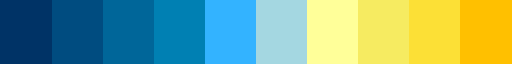

In [158]:
# All colors to create a complete legend
all_colors = ['#003366', '#004C80', '#006699',
                  '#0080B3', '#33B3FF', '#A4D7E1',
                  '#FFFF99', '#F6EB61', '#FCE036', '#FFc000']#FCE036
cmap = matplotlib.colors.ListedColormap(all_colors)#FFD700FDF502
cmap

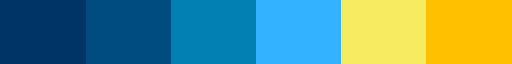

In [159]:
# Set of colors matching the elements of Bi_Class
# We have to exclude those that did not come up in the data
colors = ['#003366', # 1A
          '#004C80', # 1B
          # '#006699', # 1C
          '#0080B3', # 2A
          '#33B3FF', # 2B
          # '#FFFF99', # 2C
          '#F6EB61', # 3A
          '#FFc000'] # 3B
          # '#FDF502'] # 3C
            
cmap = matplotlib.colors.ListedColormap(colors)
cmap

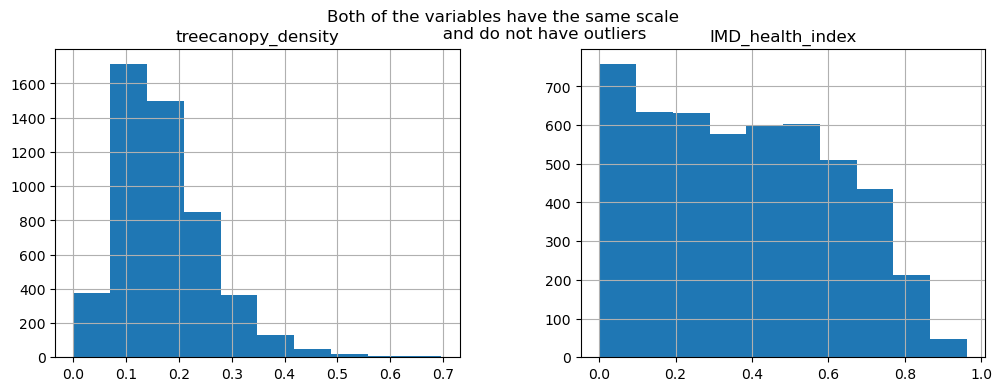

In [160]:
# Ensure data is on the same scale.
data[['treecanopy_density', 'IMD_health_index']].hist(figsize=(12,4));
plt.suptitle('Both of the variables have the same scale \n \
              and do not have outliers');

In [161]:
# Merge shape file with health and tree canopy dataset.
combined_gpd = pd.merge(gdf, data, how='inner', left_on = 'LSOA21CD', right_on = 'lsoa_code')
combined_gpd.head()

,LSOA21CD,LSOA21NM,Shape__Are,Shape__Len,geometry,IMD_health_index,mental_index,general_health_index,treecanopy_density,income_index,emp_index,air_poll_index,pct_min_ethnic,pct_senior,pct_Ed_L4+,lsoa_code,bge_type,local_authority_name
0,E01000001,City of London 001A,133759.153557,2289.743177,"POLYGON ((532105.312 182010.574, 532162.491 18...",0.022240,-1.161851,0.90,0.108141,0.000396,0.003112,0.882636,0.206242,0.250169,0.832225,E01000001,LSOA,City of London
1,E01000002,City of London 001B,225673.949043,2486.578125,"POLYGON ((532634.497 181926.016, 532619.141 18...",0.095570,-1.186594,0.91,0.041181,0.089695,0.050427,0.882636,0.222222,0.200290,0.835385,E01000002,LSOA,City of London
2,E01000003,City of London 001C,57288.376411,1142.183482,"POLYGON ((532135.138 182198.131, 532158.25 182...",0.464112,-0.863323,0.85,0.126761,0.436091,0.539933,0.870083,0.261166,0.179234,0.700997,E01000003,LSOA,City of London
3,E01000005,City of London 001E,190508.858498,2167.942170,"POLYGON ((533808.018 180767.774, 533649.037 18...",0.454759,-1.148611,0.81,0.042198,0.816219,0.761287,0.890412,0.618529,0.093236,0.403967,E01000005,LSOA,City of London
4,E01000006,Barking and Dagenham 016A,144195.364548,1935.412725,"POLYGON ((545122.049 184314.931, 545271.849 18...",0.342859,-1.064454,0.85,0.088654,0.572662,0.339323,0.640963,0.678049,0.085452,0.349195,E01000006,LSOA,Barking and Dagenham


Text(0.5, 1.0, 'Tree Canopy Density per LSOA in London')

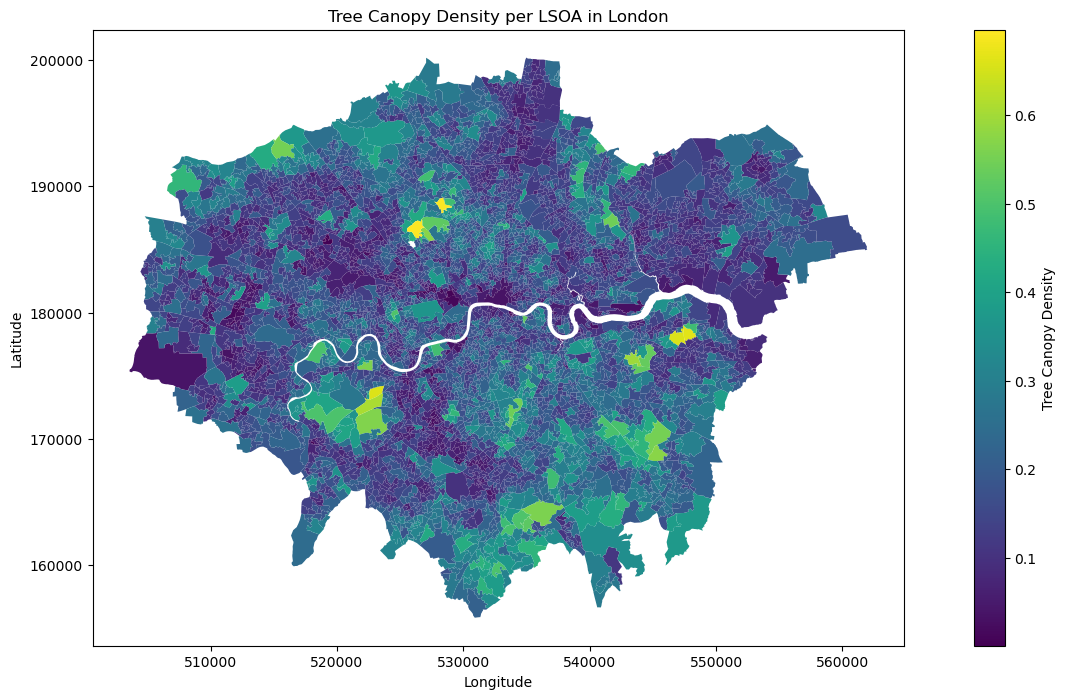

In [162]:
#Plot the Choropleth map
ax = combined_gpd.plot(column = 'treecanopy_density', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [18,8],\
                      legend_kwds = {'label': "Tree Canopy Density"}
                      )#Name the legend

# Add axes titles
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Tree Canopy Density per LSOA in London")

# Save the figure to a file
#plt.savefig("Tree Density Chloropleth.png", dpi=300, bbox_inches='tight')

In [163]:
# Make bivariate choropleth map for tree canopy vs IMD health index.

import pandas as pd
import numpy as np

# Define the bins
bins = [0, 0.33, 0.66, 1]

# Bin the first variable - x (treecanopy_density)
combined_gpd['treecanopy_density'] = pd.cut(combined_gpd['treecanopy_density'], bins=bins, include_lowest=True)
combined_gpd['treecanopy_density'] = combined_gpd['treecanopy_density'].astype('str')

# Bin the second variable - y (IMD_health_index)
combined_gpd['IMD_health_index'] = pd.cut(combined_gpd['IMD_health_index'], bins=bins, include_lowest=True)
combined_gpd['IMD_health_index'] = combined_gpd['IMD_health_index'].astype('str')

# Create x_class_codes to 1, 2, 3 for treecanopy_density
x_class_codes = np.arange(1, len(bins))  # [1, 2, 3]
d_x = dict(zip(combined_gpd['treecanopy_density'].value_counts().sort_index().index, x_class_codes))
combined_gpd['treecanopy_density'] = combined_gpd['treecanopy_density'].replace(d_x)

# Create y_class_codes to 'A', 'B', 'C' for IMD_health_index
y_class_codes = ['A', 'B', 'C']
d_y = dict(zip(combined_gpd['IMD_health_index'].value_counts().sort_index().index, y_class_codes))
combined_gpd['IMD_health_index'] = combined_gpd['IMD_health_index'].replace(d_y)

# Adjust the mapping of y_class_codes to reflect the negative correlation
# We can invert the logic for 'y_class_codes' so that higher values of x correspond to lower values of y
combined_gpd['IMD_health_index'] = combined_gpd['IMD_health_index'].map(lambda x: 'C' if x == 'A' else ('B' if x == 'B' else 'A'))

# Combine x and y codes to create Bi_Class
combined_gpd['Bi_Class'] = combined_gpd['treecanopy_density'].astype('str') + combined_gpd['IMD_health_index']

# View the result
print(combined_gpd[['treecanopy_density', 'IMD_health_index', 'Bi_Class']].head())

   treecanopy_density IMD_health_index Bi_Class
0                   1                C       1C
1                   1                C       1C
2                   1                B       1B
3                   1                B       1B
4                   1                B       1B


C:\Users\sammi\AppData\Local\Temp\ipykernel_23204\2041072028.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_gpd['treecanopy_density'] = combined_gpd['treecanopy_density'].replace(d_x)


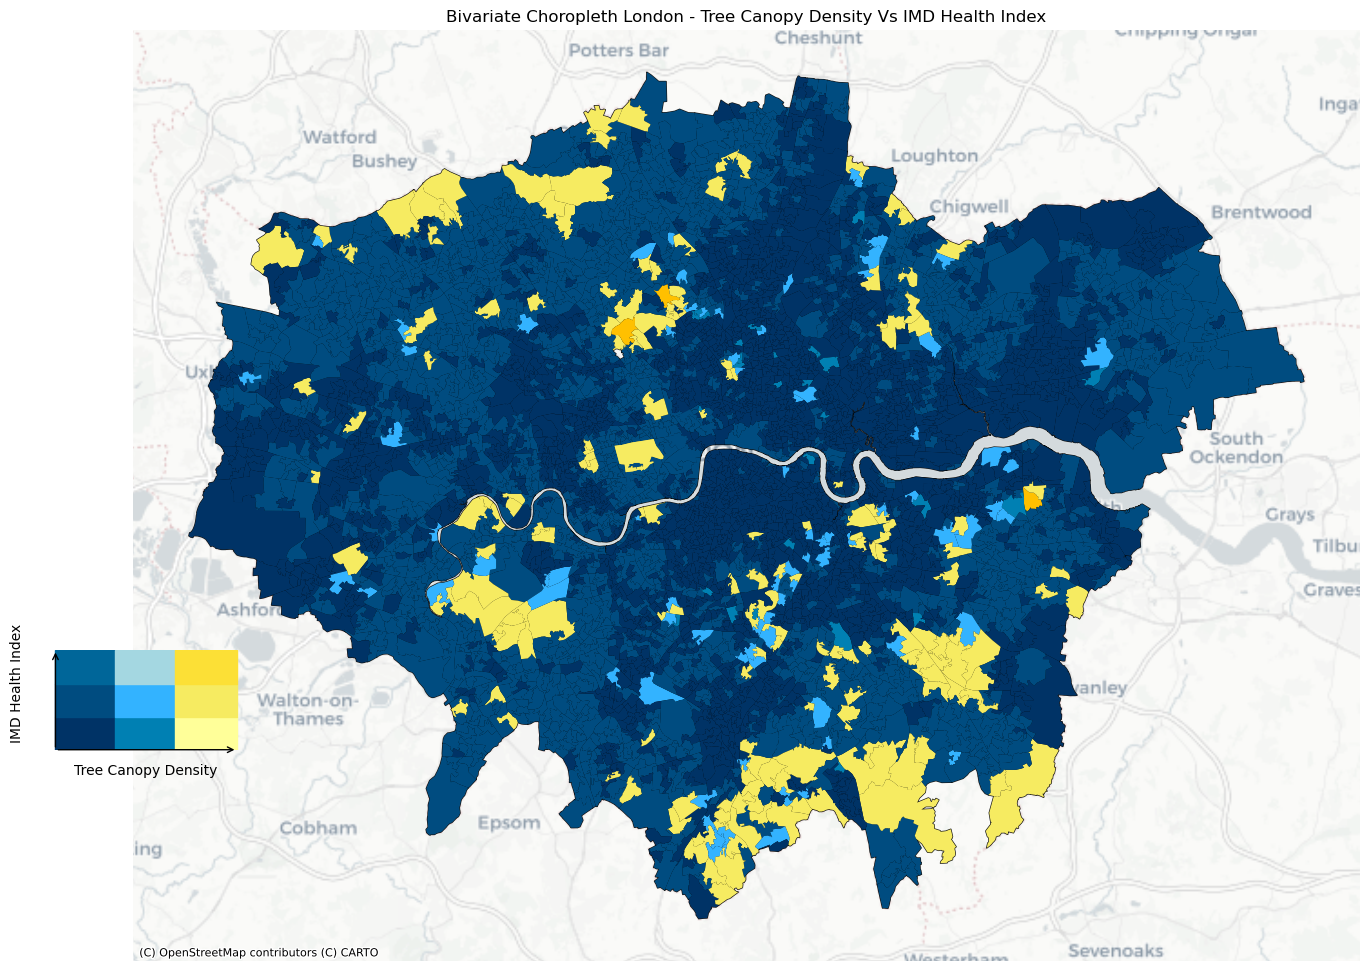

In [181]:
fig, ax = plt.subplots(figsize=(20,10))

# Step 1: Draw the map
combined_gpd.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='black', alpha=.9) # city border
combined_gpd.to_crs('EPSG:3857').plot(ax=ax, 
                              column='Bi_Class', # variable that is going to be used to color the map 
                              cmap=cmap, # newly defined bivariate cmap 
                              categorical=True, # bivariate choropleth has to be colored as categorical map 
                              legend=False) # we're going to draw the legend ourselves
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) # add the basemap

plt.tight_layout() # "tighten" two figures map and basemap
plt.axis('off') # we don't need axis with coordinates
ax.set_title('Bivariate Choropleth London - Tree Canopy Density Vs IMD Health Index')

# Step 2: draw the legend

# We're drawing a 3x3 "box" as 3 columns
# The xmin and xmax arguments axvspan are defined to create equally sized small boxes

img2 = fig # refer to the main figure
ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1]) # add new axes to place the legend there
                                         # and specify its location 
alpha = 1 # alpha argument to make it more/less transperent

# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[8])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='Tree Canopy Density', x=0.1, y=-0.25) # annotate x axis
ax2.text(s='IMD Health Index', x=-0.25, y=0.1, rotation=90); # annotate y axis
plt.savefig('TreeCanopy_VsIMD.png', dpi=300)

In [165]:
"""
Here, the bivariate choropleth map shows how tree canopy density varies with the IMD health index for each London LSOA. We can see that most
areas in London have poor health and low tree canopy density - especially in the central areas of London. We can also clearly see a line of
division between East and West London. ** Explain the lack of blue tiles in North-West London and the pocket of greenery in SE London - this
is where a lot of high-income people are located. Overall, high tree-density areas look to be located on the outskirts of the city. 
As just mentioned, this coincides with income, i.e., higher-income areas have greater tree density.

Some areas with the highest tree densities are Camden, Haringey in north London, and Bexley in south-east London. Some of the least tree-dense
areas are Brent and Westminster. Interestingly, Brent is located in far north London and Westminster is very central. This shows that whilst
London has a large amount of greenspace, densely populated areas within Central London are predominantly concrete and have very few trees.

One problem we found with using this dataset's IMD and tree canopy density is that they are quite skewed. The dataset reveals that more people
have bad health than good health. This is unusual, but this could be a problem of using health indexes derived from deprivation measures. Perhaps,
we could use rates of respiratory diseases or cardiovascular diseases. However, we found this data is rarely collected at the LSOA level, making
it unsuitable for this analysis. Nonetheless, on the analysis side, since the dataset provides normalised values of health indices and tree canopy 
density, the problems with skewness are somewhat limited.

In terms of policy action, greater afforestation within city streets should take place in low-income areas within central London should take  
priority. This would help the most vulnerable people achieve greater access to the range of benefits that trees can provide in urban areas (Wolch et al., 2011;
Mcdonald et al., 2016)


Wolch, J., Jerrett, M., Reynolds, K., McConnell, R., Chang, R., Dahmann, N. and Su, J. 2011. Childhood obesity and proximity to urban parks and recreational resources: 
A longitudinal cohort study. Health & Place, 17(1), pp.207-214. Available at: https://doi.org/10.1016/j.healthplace.2010.09.001.

McDonald, R.I., Elmqvist, T., Gronlund, C., Hartig, T., Harlan, S., and van den Bosch, M. 2016. Planting Healthy Air: A global analysis of the role of urban trees in 
addressing particulate matter pollution and extreme heat. The Nature Conservancy, Arlington, VA. Available at: www.nature.org/healthyair [Accessed 21 February 2025].
"""

'\nHere, the bivariate choropleth map shows how tree canopy density varies with the IMD health index for each London LSOA. We can see that most\nareas in London have poor health and low tree canopy density - especially in the central areas of London. We can also clearly see a line of\ndivision between East and West London. ** Explain the lack of red tiles in North-West London and the pocket of greenery in SE London - this\nis where a lot of high-income people are located. Overall, high tree-density areas look to be located on the outskirts of the city. \nInterestingly, this coincides with income, i.e., higher-income areas have greater tree density. \n\nSome areas with the highest tree densities are Camden, Haringey in north London, and Bexley in south-east London. Some of the least tree-dense\nareas are Brent and Westminster. Interestingly, Brent is located in far north London and Westminster is very central. This shows that whilst\nLondon has a large amount of greenspace, densely popu

In [166]:
combined_gpd.head()

,LSOA21CD,LSOA21NM,Shape__Are,Shape__Len,geometry,IMD_health_index,mental_index,general_health_index,treecanopy_density,income_index,emp_index,air_poll_index,pct_min_ethnic,pct_senior,pct_Ed_L4+,lsoa_code,bge_type,local_authority_name,Bi_Class
0,E01000001,City of London 001A,133759.153557,2289.743177,"POLYGON ((532105.312 182010.574, 532162.491 18...",C,-1.161851,0.90,1,0.000396,0.003112,0.882636,0.206242,0.250169,0.832225,E01000001,LSOA,City of London,1C
1,E01000002,City of London 001B,225673.949043,2486.578125,"POLYGON ((532634.497 181926.016, 532619.141 18...",C,-1.186594,0.91,1,0.089695,0.050427,0.882636,0.222222,0.200290,0.835385,E01000002,LSOA,City of London,1C
2,E01000003,City of London 001C,57288.376411,1142.183482,"POLYGON ((532135.138 182198.131, 532158.25 182...",B,-0.863323,0.85,1,0.436091,0.539933,0.870083,0.261166,0.179234,0.700997,E01000003,LSOA,City of London,1B
3,E01000005,City of London 001E,190508.858498,2167.942170,"POLYGON ((533808.018 180767.774, 533649.037 18...",B,-1.148611,0.81,1,0.816219,0.761287,0.890412,0.618529,0.093236,0.403967,E01000005,LSOA,City of London,1B
4,E01000006,Barking and Dagenham 016A,144195.364548,1935.412725,"POLYGON ((545122.049 184314.931, 545271.849 18...",B,-1.064454,0.85,1,0.572662,0.339323,0.640963,0.678049,0.085452,0.349195,E01000006,LSOA,Barking and Dagenham,1B
